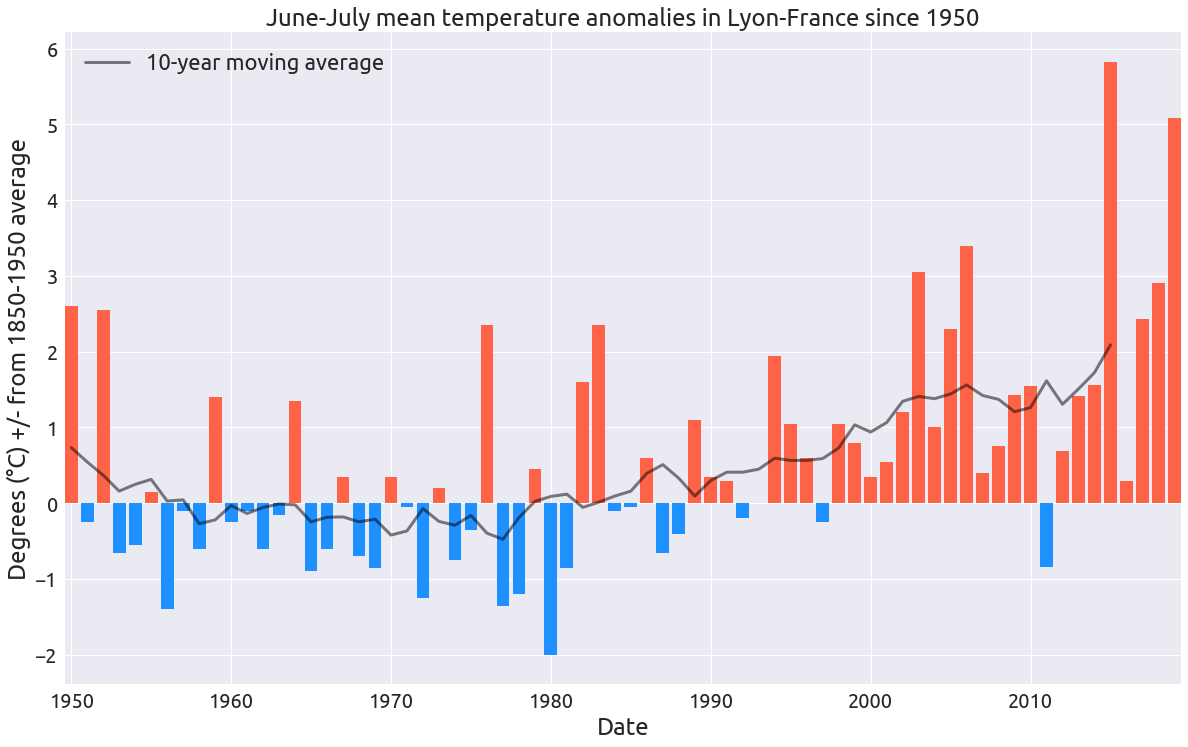

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import calendar
from io import StringIO
%matplotlib inline
plt.style.use('seaborn')

# figure parameters
fs = (20, 12)
matplotlib.rcParams.update({
    'legend.fontsize': 22,
    'legend.title_fontsize': 26,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.labelsize': 24,
    'axes.titlesize': 24,
    'font.family': 'ubuntu'})

# Temperature data preparation
#=============================

# df1: 1743-2013 temperatures
# Historical monthly temperature data of Lyon from http://berkeleyearth.lbl.gov]
# http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/45.81N-5.77E-TAVG-Trend.txt) 

with open('45.81N-5.77E-TAVG-Trend.txt') as f:
    content = f.read()
content = content.replace(',', ' ')
content = content.replace('%', ' ')
sio = StringIO(content)
df1 = pd.read_csv(sio, delim_whitespace=True, skiprows=66).reset_index().iloc[:, 0:5]
df1.drop('index', axis='columns', inplace=True)
# Mean absolute temperatures 
mat = pd.DataFrame({
    'Month': np.arange(1, 13),
    'T_MAT': [-0.22, 1.3, 4.49, 7.75, 12.19, 15.62, 17.88, 17.10, 14.12, 9.10, 4.11, 0.82]})
df1 = pd.merge(df1, mat, on='Month', how='left')
df1['temp'] = df1.T_MAT + df1.Anomaly
df1.drop(['Anomaly', 'Unc.', 'T_MAT'], axis='columns', inplace=True)
df1.rename(columns={'Year': 'year', 'Month': 'month'}, inplace=True)
df1['day'] = 1
df1["date"] = pd.to_datetime(df1[['year', 'month', 'day']])
df1.set_index("date", inplace=True)
df1.drop(['year', 'month', 'day'], axis=1, inplace=True)

# df2: 1901-2016 temperatures
# Historical monthly temperature data of Lyon from worldbank
# https://climateknowledgeportal.worldbank.org/download-data

df2 = pd.read_csv('tas_1901_2016_4.942764_45.724942.csv', usecols=['Temperature - (Celsius)', ' Year', ' Statistics'])
df2.rename(columns={'Temperature - (Celsius)': 'temp', ' Year': 'year', ' Statistics': 'month'}, inplace=True)
df2.month = df2.month.map(lambda s: s.strip().split(' ')[0])
df2['date'] = pd.to_datetime(df2['year'].astype(str) + df2['month'], format='%Y%b')
df2.set_index('date', inplace=True)

# df3: 2009-2019 temperatures
# We download the historical daily temperature data of Lyon from historique-meteo.net
# https://www.historique-meteo.net/france/rh-ne-alpes/lyon/
df3 = pd.read_csv('export-lyon.csv', skiprows=3, usecols=['DATE', 'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C'])
df3.rename(columns={'DATE': 'date'},inplace=True)
df3.date = pd.to_datetime(df3.date)
df3.set_index('date', inplace=True)
df3['temp'] = 0.4 * df3['TEMPERATURE_MORNING_C'] + 0.2 * df3['TEMPERATURE_NOON_C'] + 0.4 * df3['TEMPERATURE_EVENING_C']
df3.drop(['TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C'], axis='columns', inplace=True)
df3 = df3.resample('MS').mean()

# df1 vs df2 temperatures
df1.temp += (df2.temp-df1.temp).mean()

# Aggregate all data : 1743-2019
df1['year'] = df1.index.year
df1['month'] = [calendar.month_abbr[i] for i in df1.index.month.to_list()]
df3['year'] = df3.index.year
df3['month'] = [calendar.month_abbr[i] for i in df3.index.month.to_list()]
df = pd.concat([df1[:'1900'], df2['1901':'2008'], df3['2009':]], axis='rows')

# Temperature data analysis
#==========================

df_summer = df[df.month.isin(['Jun', 'Jul'])].resample('Y').mean().temp
t_summer = df_summer['1850':'1950'].mean()

anomaly = (df_summer - t_summer).copy(deep=True).to_frame('anomaly')
anomaly['label'] = anomaly.index.year.astype(str)
anomaly.loc[anomaly['label'].str[-1] != '0', 'label'] = ''
rw = anomaly.anomaly.rolling(10, center=True).mean().to_frame('window')

start = '1950'
fig, ax = plt.subplots(figsize=fs)
mask = (anomaly[start:].anomaly > 0)
colors = np.array(['dodgerblue'] * len(anomaly[start:]))
colors[mask.values] = 'tomato'
plt.bar(anomaly[start:].index.year, anomaly[start:].anomaly, color=colors)
plt.plot(rw[start:].index.year.tolist(), rw[start:].window.values, 'k', linewidth=3, alpha=0.5, label='10-year moving average')

ax.legend()
ax.set_xlabel('Date');
ax.set_ylabel('Degrees (°C) +/- from 1850-1950 average');
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_title(f'June-July mean temperature anomalies in Lyon-France since {start}');